In [2]:
library(SingleR)
library(Seurat)
library(ggplot2)
library(cowplot)
library(RColorBrewer)
library(crunch)
library(testSctpa)
library(SingleCellExperiment)
library("scPred")
library(dplyr)
library(scran)
library(scater)
library(GSVA)
setwd('/share2/pub/zhangyr/zhangyr/single-RNA/cellTypeAnno')

In [73]:
reference = read.csv('./data/Chromium10X_V3.csv',row.names = 1)
target = read.csv('./data/Smart_seq_V2.csv',row.names = 1)

reference_meta = read.csv('./data/meta_Chromium10X_V3.csv',row.names = 1)
target_meta = read.csv('./data/meta_Smart_seq_V2.csv',row.names = 1)

In [74]:
reference_se = CreateSeuratObject(reference)
reference_se = SCTransform(reference_se)
reference_se[['umap']] = CreateDimReducObject(as.matrix(reference_meta[,c('UMAP_1','UMAP_2')]))
reference_se$cellType = reference_meta$cellType

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19282 by 1185

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1185 cells



  |======================================================================| 100%


Found 63 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19282 genes



  |======================================================================| 100%


Computing corrected count matrix for 19282 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 25.50445 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Warning message:
“No assay specified, setting assay as RNA by default.”


In [46]:
target_se = CreateSeuratObject(target)
target_se = SCTransform(target_se)
target_se[['umap']] = CreateDimReducObject(as.matrix(target_meta[,c('UMAP_1','UMAP_2')]))
target_se$cellType = target_meta$cellType

Warning message:
“No assay specified, setting assay as RNA by default.”


In [45]:
head(as.matrix(reference_meta[,c('UMAP_1','UMAP_2')]))

,UMAP_1,UMAP_2
10X2x5K_64221_AAACCTGCACTTCGAA,4.737702,-10.8620260
10X2x5K_64221_AAACCTGCAGTACACT,-5.406447,0.1207662
10X2x5K_64221_AAACCTGTCCACTGGG,-6.246908,-4.4772036
10X2x5K_64221_AAACGGGCACACGCTG,-5.888989,-6.2547734
10X2x5K_64221_AAACGGGCACCAGCAC,-6.640662,-5.4033687
10X2x5K_64221_AAACGGGGTGAAAGAG,-6.685816,-5.1515348


# GSVA

In [5]:
markers = testSctpa::getGMT('./data/markers_Chromium10X_V3.gmt')
names(markers)

[1] "B_cells"          "CD4_T_cells_2"    "CD4_T_cells_1"    "CD14_Monocytes"  
[5] "NK_cells"         "CD8_T_cells"      "FCGR3A_Monocytes"

In [7]:
gsva_score = gsva(as.matrix(target),gset.idx.list = markers)

Warning message in .filterFeatures(expr, method):
“4439 genes with constant expression values throuhgout the samples.”
Warning message in .filterFeatures(expr, method):
“Since argument method!="ssgsea", genes with constant expression values are discarded.”


Estimating GSVA scores for 7 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



In [8]:
gsva_score[1:5,1:5]

,SMARTseqFINAL_allLanes_AACATCCGAAGAGAGG,SMARTseqFINAL_allLanes_AACATCCGCAGTATCG,SMARTseqFINAL_allLanes_AACATCCGCCTCCTAA,SMARTseqFINAL_allLanes_AACATCCGCGAATCTG,SMARTseqFINAL_allLanes_AACATCCGCGCCTATA
B_cells,-0.3692641,-0.31874210,0.6918879,-0.2138588,-0.3849233
CD4_T_cells_2,-0.6282848,-0.58980451,-0.5769585,-0.7106241,-0.5589940
CD4_T_cells_1,-0.8507820,-0.81485716,-0.7273477,-0.8689512,-0.8357150
CD14_Monocytes,-0.3568470,-0.09823466,-0.4332448,-0.1906096,-0.1258880
NK_cells,0.7291244,0.70871182,-0.7957188,0.6298826,0.5660532


In [11]:
gsva_pred = rownames(gsva_score)[apply(gsva_score,2,which.max)]

In [25]:
target_se$gsva_pred = gsva_pred

Warning message:
“No assay specified, setting assay as RNA by default.”


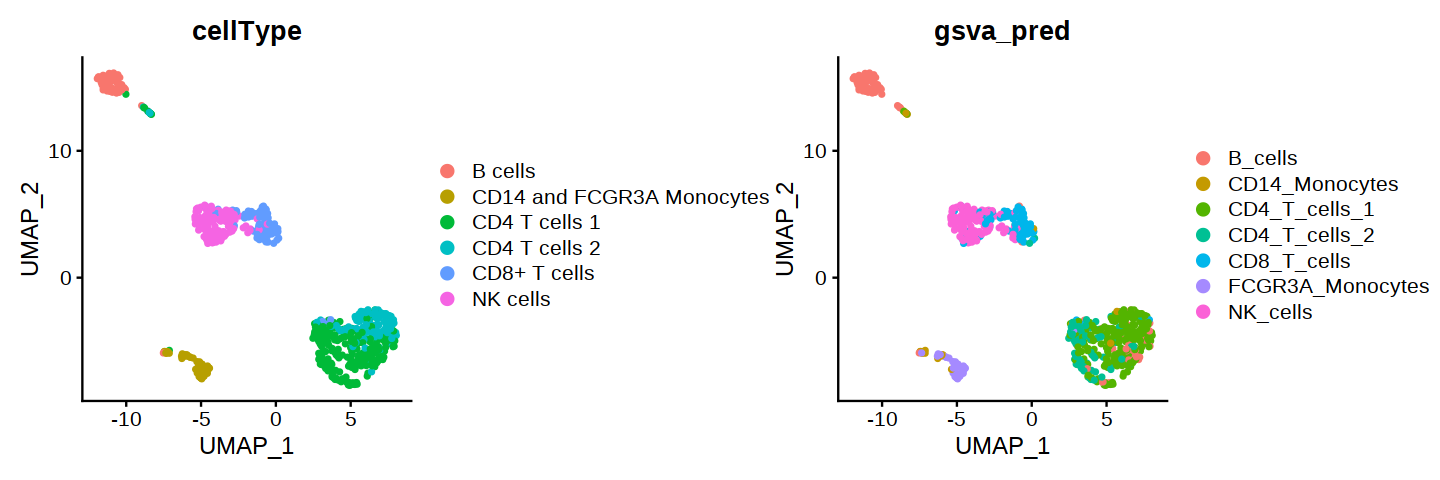

In [30]:
options(repr.plot.width=12, repr.plot.height=4)
DimPlot(target_se, group.by = c('cellType','gsva_pred'))

# SingleR

In [60]:
reference_sc = SingleCellExperiment(assays=list(counts=reference_se@assays$SCT@counts, 
                                                logcounts=reference_se@assays$SCT@data))
reference_sc$label = reference_se$cellType
target_sc = SingleCellExperiment(assays=list(counts=target_se@assays$SCT@counts, 
                                             logcounts=target_se@assays$SCT@data))

In [61]:
SingleR_pred = SingleR(test=target_sc, ref=reference_sc, 
                       labels=reference_sc$label, de.method="wilcox")

In [65]:
head(data.frame(SingleR_pred))

,scores.B.cells,scores.CD14.Monocytes,scores.CD4.T.cells.1,scores.CD4.T.cells.2,scores.CD8.T.cells,scores.FCGR3A.Monocytes,scores.NK.cells,first.labels,tuning.scores.first,tuning.scores.second,labels,pruned.labels
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
SMARTseqFINAL_allLanes_AACATCCGAAGAGAGG,0.2946652,0.2516231,0.3901489,0.4108971,0.6152920,0.2776556,0.7063149,NK cells,0.7063149,0.6152920,NK cells,NK cells
SMARTseqFINAL_allLanes_AACATCCGCAGTATCG,0.1896457,0.1764998,0.3767001,0.3924316,0.5768767,0.1997975,0.6557510,NK cells,0.6557510,0.5768767,NK cells,NK cells
SMARTseqFINAL_allLanes_AACATCCGCCTCCTAA,0.7402620,0.3863376,0.3904467,0.3892184,0.3574055,0.4047786,0.3321049,B cells,0.7402620,0.4047786,B cells,B cells
SMARTseqFINAL_allLanes_AACATCCGCGAATCTG,0.2219552,0.2136755,0.3461293,0.3641899,0.5562716,0.2259601,0.6503161,NK cells,0.6503161,0.5562716,NK cells,NK cells
SMARTseqFINAL_allLanes_AACATCCGCGCCTATA,0.2715128,0.2103340,0.3563678,0.3740576,0.5737621,0.2626281,0.6682077,NK cells,0.6682077,0.5737621,NK cells,NK cells
SMARTseqFINAL_allLanes_AACATCCGCGGAAGAA,0.2526117,0.2813196,0.3610432,0.3849236,0.5629391,0.2890762,0.6515479,NK cells,0.6515479,0.5629391,NK cells,NK cells


In [66]:
target_se$SingleR_pred = SingleR_pred[,'labels']

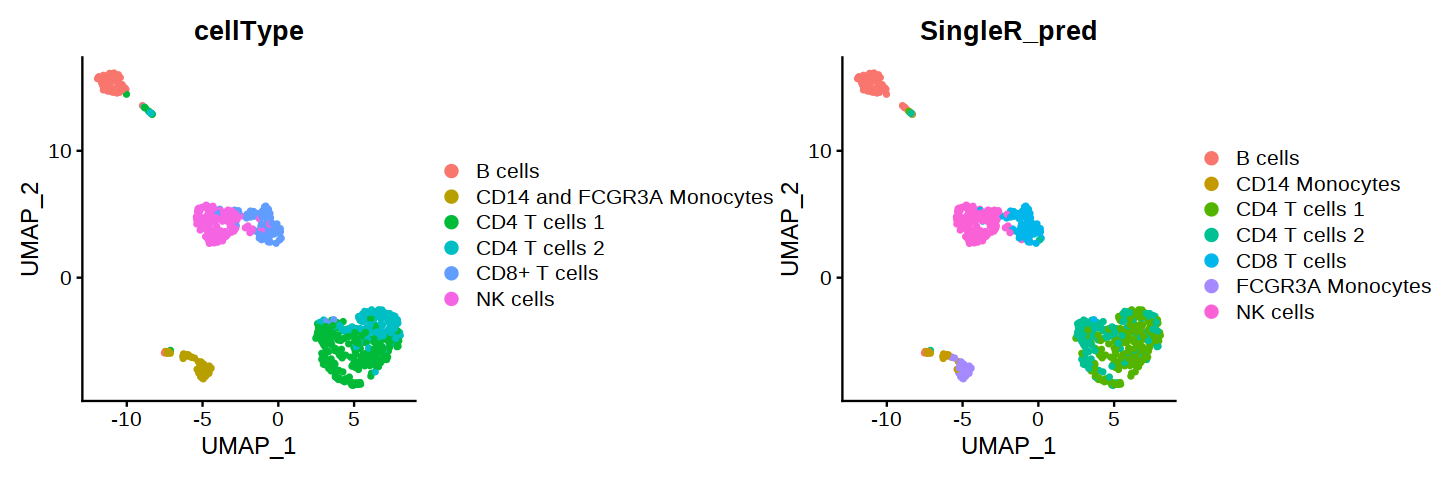

In [67]:
options(repr.plot.width=12, repr.plot.height=4)
DimPlot(target_se, group.by = c('cellType','SingleR_pred'))

# scPred

In [75]:
reference_se = reference_se %>% 
  NormalizeData() %>% 
  FindVariableFeatures() %>% 
  ScaleData() %>% 
  RunPCA()

Centering and scaling data matrix

PC_ 1 
Positive:  CST3, FCN1, LST1, S100A9, PLXDC2, CLEC7A, S100A8, AC007192.4, CTSS, AC109326.1 
	   NAMPT, HCK, WDR74, RBM47, VCAN, C10orf11, PSAP, IL1B, TYROBP, CD83 
	   GAB2, FTL, DMXL2, PLAUR, AIF1, TEX14, GPX1, SLC8A1, KLF4, SPI1 
Negative:  SKAP1, RPS27, RPL3, RPS29, RP11-761N21.2, CCND3, PRKCH, CD247, DAPK1, BCL11B 
	   RPS6, AC005062.3, RPL21, RPS18, MALAT1, CD3D, SCML4, EEF1A1P5, LTB, IL7R 
	   TRAC, CAMK4, TNIK, RPS12, ARHGAP15, PCED1B, IL32, INPP4B, TRBC2, ITK 
PC_ 2 
Positive:  NKG7, GNLY, KLRD1, CST7, CCL5, TGFBR3, FGFBP2, GZMA, PRF1, GZMB 
	   KLRF1, SPON2, MYO1F, KLRB1, HOPX, GZMH, CTSW, RAP1GAP2, CCL4, C1orf21 
	   TRDC, HCST, KLRC4-KLRK1, NCALD, AOAH, IFITM2, PFN1, B2M, S100A4, FCRL6 
Negative:  AFF3, LTB, BACH2, CD79A, PAX5, TNFRSF13C, IGHM, RP11-358M11.2, RALGPS2, FAM129C 
	   EBF1, BANK1, MS4A1, OSBPL10, FCRL1, BCL11A, ADAM28, GNG7, FOXP1, BLK 
	   IGHD, STRBP, RPS18, AC096579.15, CD79B, WDFY4, STAP1, MAML2, ADAM19, COL19A1 
PC_ 

In [76]:
reference_se = getFeatureSpace(reference_se, "cellType")

●  Extracting feature space for each cell type...
DONE!


In [77]:
reference_se = trainModel(reference_se)

●  Training models for each cell type...


Loading required package: lattice



DONE!


In [84]:
target_se = scPredict(target_se, reference_se)

●  Matching reference with new dataset...
	 ─ 2000 features present in reference loadings
	 ─ 1773 features shared between reference and new dataset
	 ─ 88.65% of features in the reference are present in new dataset
●  Aligning new data to reference...


Harmony 1/20

Harmony 2/20

Harmony converged after 2 iterations



●  Classifying cells...
DONE!


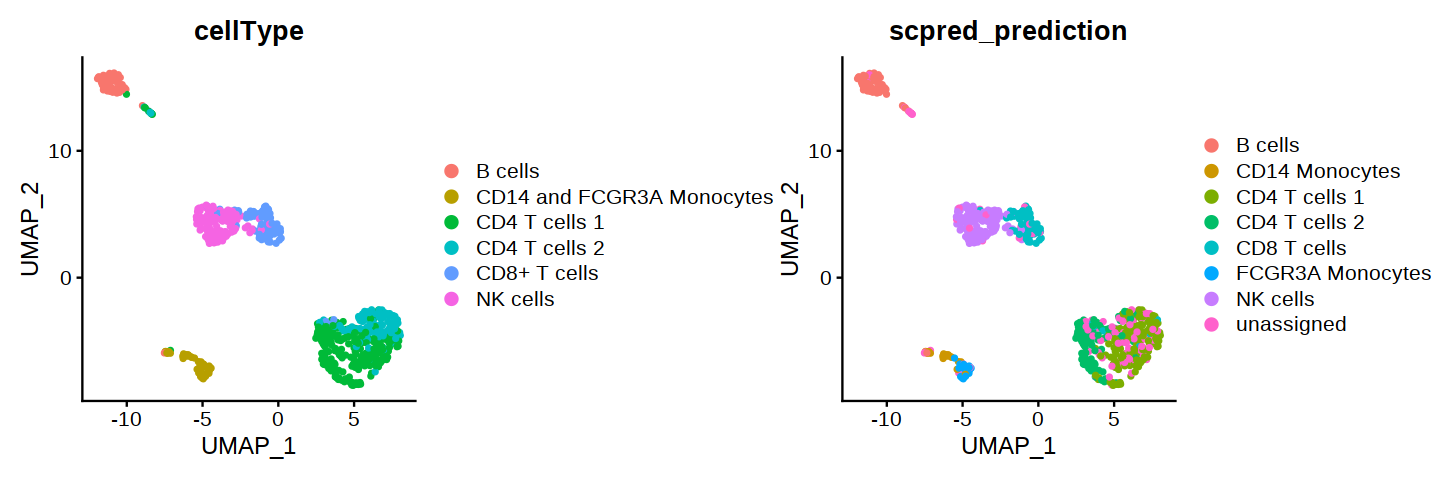

In [86]:
DimPlot(target_se, group.by = c('cellType','scpred_prediction'))